<a href="https://colab.research.google.com/github/olyaee/3D_semgentation/blob/master/3D_cardiac_semgentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/drive')

In [3]:
import numpy as np  # For data manipulation
import glob  # For populating the list of files
import matplotlib.pyplot as plt
import nibabel as nib

import os
import h5py

from ipywidgets import interact, interactive, IntSlider, ToggleButtons

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense, MaxPooling3D
from tensorflow.keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow_addons.layers import GroupNormalization

import zipfile  # For faster extraction

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(tf.__version__)

2.1.0


In [4]:
a = np.array([3, 4, 5, 5, 2, 5, 8])
print(a)
a[a==5]=0
print(a)
DIR_DATA = glob.glob('/drive/My Drive/data/boston/boston/*')
DIR_DATA = glob.glob('/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/*')
print(DIR_DATA)

[3 4 5 5 2 5 8]
[3 4 0 0 2 0 8]
['/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat2-subvolume.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat12-subvolume-normalized.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat1-subvolume-normalized.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat12-Segmentation-smoothed.seg.nrrd', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat1-Segmentation-smoothed.seg.nrrd', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat28-Segmentation-smoothed-label.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat1-subvolume.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat5-subvolume-normalized.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat1-Segmentation-smoothed-label.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat28-subvolume-normalized.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat12-subvolume.nii.gz', '/home/

In [0]:
# DIR_DATA='/drive/My Drive/data/boston/boston/'
DIR_DATA='/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/'

ORIGINAL_SHAPE = (155, 240, 240)
INPUT_SHAPE = (160, 160, 16)
# INPUT_SHAPE = (50, 64, 32)
EPOCHS = 10
DIR_DATA_PROCESSED = '/hd9'
DIR_DATA_PROCESSED = '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed'

In [6]:
# Get a list of files for all modalities individually
list_path_input = sorted(glob.glob(DIR_DATA+'*-subvolume-normalized.nii.gz'))[-2:]
list_path_gt = sorted(glob.glob(DIR_DATA+'*-Segmentation-smoothed-label.nii.gz'))[-2:]

print(list_path_input)
len_data = len(list_path_input)
print('len_data', len_data)

assert len(list_path_input)==len(list_path_gt)

['/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat28-subvolume-normalized.nii.gz', '/home/olyaeeen/Desktop/facetVISIONnet/boston/boston/pat5-subvolume-normalized.nii.gz']
len_data 2


In [7]:
def generate_patches(len_data, dir_output, num_patches, shape_output, normalize=False, background_threshold=.60, max_tries=100000):
  # if os.path.isdir(dir_output):
  #   print('error: output folder already exists')
  #   return None
  # else:
  #   os.mkdir(dir_output)

  for i in range(len_data):

    gt = np.array(nib.load(list_path_gt[i]).get_fdata())
    gt[gt>8.]=0.
    # print(np.unique(gt))

    # print(gt.shape)


    input =  np.array(nib.load(list_path_input[i]).get_fdata())
    # print(input.shape)
    
    orig_x, orig_y, orig_z = input.shape[:]
    output_x, output_y, output_z = shape_output
    # output_x, output_y, output_z = input.shape[:]

    X = None
    y = None

    tries = 0
    patches_extracted = 0
    
    while(tries<max_tries and patches_extracted<num_patches):
      start_x = np.random.randint(orig_x - output_x + 1)
      start_y = np.random.randint(orig_y - output_y + 1)
      start_z = np.random.randint(orig_z - output_z + 1)


      # extract relevant area of label
      y = gt[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

      y = tf.keras.utils.to_categorical(y, num_classes=9)

      # print(y.shape)
      bgrd_ratio = np.sum(y[:, :, :, 0])/(y[:, :, :, 0]).size
      tries+=1
      print('try ', tries, bgrd_ratio)

      if bgrd_ratio < background_threshold:
        
        # make copy of the sub-volume
        X = np.copy(input[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z])
        
        X = np.expand_dims(X, axis=0)

        y = np.moveaxis(y, -1, 0)

        if normalize:
          X = standardize(X)
        
        y = y[1:, :, :, :]

        # print(X.shape, y.shape)

        
        patches_extracted+=1
        with h5py.File('{}/{}_{}.h5'.format(dir_output, str(i).zfill(3), str(patches_extracted).zfill(3)), 'w') as hf:
                hf.create_dataset("image",  data=X)
                hf.create_dataset("label",  data=y)

        # return X, y

a = generate_patches(1,DIR_DATA_PROCESSED, 10, INPUT_SHAPE)

try  1 0.71642578125
try  2 1.0
try  3 0.7631396484375
try  4 0.8021484375
try  5 0.72316162109375
try  6 0.7863671875
try  7 0.65609619140625
try  8 0.92651123046875
try  9 0.61243896484375
try  10 0.64122802734375
try  11 0.80554931640625
try  12 0.655859375
try  13 0.84090087890625
try  14 0.653349609375
try  15 0.63328369140625
try  16 0.8198876953125
try  17 0.71596435546875
try  18 0.6075634765625
try  19 0.76677001953125
try  20 0.50861328125
try  21 0.6898779296875
try  22 0.51094970703125
try  23 0.44341064453125
try  24 0.75279052734375
try  25 0.85970703125
try  26 0.74451904296875
try  27 0.49830810546875
try  28 0.513349609375
try  29 0.7518212890625
try  30 0.8225732421875
try  31 0.9323681640625
try  32 0.87828857421875
try  33 0.5021435546875
try  34 0.9811474609375
try  35 0.89936767578125
try  36 0.8151318359375
try  37 0.68563232421875
try  38 0.77121337890625
try  39 0.61968994140625
try  40 0.96418701171875
try  41 0.8026318359375
try  42 0.68407958984375
try  43 0

In [28]:
data = glob.glob('{}/*.h5'.format(DIR_DATA_PROCESSED))
print(data)
with h5py.File(data[0], 'r') as hf:
    img = np.array(hf.get("image"))
    label = np.array(hf.get("label"))

print(img.shape, label.shape)

def display(data, num_ch=3, slice=45):
  # if num_ch==4:
  #   titles = ['t1', 't2', 'flair', 't1ce']
  # elif num_ch==3:
  #   titles = ['ncr', 'ed', 'et']
  plt.figure(figsize=(15, 15))
  for i in range(num_ch):
    plt.subplot(4, 4, i+1)
    # plt.title(titles[i])
    plt.imshow(data[i, :, :, slice], cmap='gray')
    plt.axis('off')
  plt.show()  

def explore_3dimage(layer):

  plt.figure(figsize=(15, 15))
  display(img, 1, layer)
  display(label, 8, layer)

interact(explore_3dimage, layer=(0, 16 - 1));



['/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_010.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_001.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_006.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_009.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_004.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_002.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_007.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_003.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_005.h5', '/home/olyaeeen/Desktop/facetVISIONnet/boston/processed/000_008.h5']
(1, 160, 160, 16) (8, 160, 160, 16)


interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

In [0]:
import random
data = glob.glob('{}/*.h5'.format(DIR_DATA_PROCESSED))
# print(data)

def read_path(list_path, shape=None):
  def f():
    random.shuffle(list_path)
    for path in list_path:
      # print(path)
      with h5py.File(path, 'r') as hf:
        img = np.array(hf.get("image"))
        label = np.array(hf.get("label"))

      yield (img, label)
  return f

ds = tf.data.Dataset.from_generator(read_path(data), (tf.float32, tf.float32), output_shapes=((1, 160, 160, 16),(8, 160, 160, 16)))
ds = ds.repeat().batch(2)
# for epoch in range(3):
#   for img, label in ds:
#     print(img.shape, label.shape)
#   print('dddddddddddddddd')


In [10]:
sample_input, sample_label = next(iter(ds.skip(3)))
print(sample_input.shape)
print(sample_label.shape)
print('max', tf.reduce_max(sample_input))
print('min', tf.reduce_min(sample_input))
print('mean', tf.math.reduce_mean(sample_input))
print('std', tf.math.reduce_std(sample_input))
# display(sample_input, num_ch=4)
# display(sample_label, num_ch=3)

bgrd_ratio = (tf.size(sample_label[0, 0, :, :, :], out_type=tf.float32)-tf.math.reduce_sum(sample_label))/(tf.size(sample_label[0, 0, :, :, :], out_type=tf.float32))

print(tf.size(sample_label[0, 0, :, :, :], out_type=tf.float32))
print(tf.math.reduce_sum(sample_label))
print(bgrd_ratio)


(2, 1, 160, 160, 16)
(2, 8, 160, 160, 16)
max tf.Tensor(1.3666704, shape=(), dtype=float32)
min tf.Tensor(-0.004505425, shape=(), dtype=float32)
mean tf.Tensor(0.5190672, shape=(), dtype=float32)
std tf.Tensor(0.3147123, shape=(), dtype=float32)
tf.Tensor(409600.0, shape=(), dtype=float32)
tf.Tensor(406765.0, shape=(), dtype=float32)
tf.Tensor(0.006921387, shape=(), dtype=float32)


In [0]:
tf.keras.backend.set_image_data_format("channels_first")

def create_convolution_block(input_layer, n_filters, batch_normalization=False,
                             kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1),
                             instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(
        input_layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2),
                       strides=(2, 2, 2),
                       deconvolution=False):
    if deconvolution:
        return Deconvolution3D(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)


def unet_model_3d(loss_function, input_shape=(1, None, None, None),
                  pool_size=(2, 2, 2), n_labels=8,
                  initial_learning_rate=0.00001,
                  deconvolution=False, depth=4, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[],
                  batch_normalization=False, activation_name="sigmoid"):
    """
    Builds the 3D UNet Keras model.f
    :param metrics: List metrics to be calculated during model training (default is dice coefficient).
    :param include_label_wise_dice_coefficients: If True and n_labels is greater than 1, model will report the dice
    coefficient for each label as metric.
    :param n_base_filters: The number of filters that the first layer in the convolution network will have. Following
    layers will contain a multiple of this number. Lowering this number will likely reduce the amount of memory required
    to train the model.
    :param depth: indicates the depth of the U-shape for the model. The greater the depth, the more max pooling
    layers will be added to the model. Lowering the depth may reduce the amount of memory required for training.
    :param input_shape: Shape of the input data (n_chanels, x_size, y_size, z_size). The x, y, and z sizes must be
    divisible by the pool size to the power of the depth of the UNet, that is pool_size^depth.
    :param pool_size: Pool size for the max pooling operations.
    :param n_labels: Number of binary labels that the model is learning.
    :param initial_learning_rate: Initial learning rate for the model. This will be decayed during training.
    :param deconvolution: If set to True, will use transpose convolution(deconvolution) instead of up-sampling. This
    increases the amount memory required during training.
    :return: Untrained 3D UNet Model
    """
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        layer1 = create_convolution_block(input_layer=current_layer,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth),
                                          batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1,
                                          n_filters=n_base_filters * (
                                                  2 ** layer_depth) * 2,
                                          batch_normalization=batch_normalization)

        if layer_depth < depth - 1:
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        else:
            current_layer = layer2
            levels.append([layer1, layer2])

    # add levels with up-convolution or up-sampling
    for layer_depth in range(depth - 2, -1, -1):
        up_convolution = get_up_convolution(pool_size=pool_size,
                                            deconvolution=deconvolution,
                                            n_filters=
                                            current_layer._shape_val[1])(
            current_layer)
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=1)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._shape_val[1],
            input_layer=concat, batch_normalization=batch_normalization)
        current_layer = create_convolution_block(
            n_filters=levels[layer_depth][1]._shape_val[1],
            input_layer=current_layer,
            batch_normalization=batch_normalization)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model



In [0]:
def soft_dice_loss(y_true, y_pred, axis=(0, 1, 2), 
                                  epsilon=0.0000001):
    """
    Compute dice coefficient for single class.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for single class.
                                    shape: (x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of predictions for single class.
                                    shape: (x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator of dice coefficient.
                      Hint: pass this as the 'axis' argument to the K.sum function.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn =  tf.reduce_sum(tf.square(y_true) + tf.square(y_pred), axis=[-3,-2,-1]) + epsilon
        
    return 1 - tf.reduce_mean(2 * intersection / dn, axis=[0,1])
    
    ### END CODE HERE ###

Train for 5 steps
Epoch 1/1000
4/5 [=======================>......] - ETA: 1s - loss: 0.8499

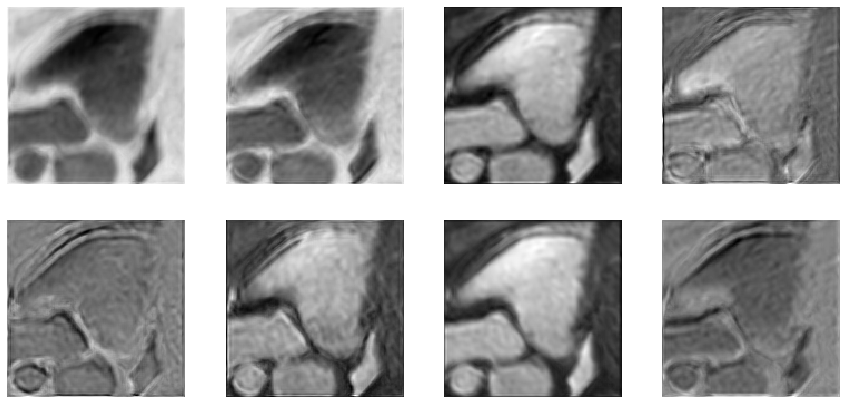

5/5 [==============================] - 8s 2s/step - loss: 0.8516
Epoch 2/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8513
Epoch 3/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8510
Epoch 4/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8508
Epoch 5/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8504
Epoch 6/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8499
Epoch 7/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8491
Epoch 8/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8478
Epoch 9/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8463
Epoch 10/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8451
Epoch 11/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8432
Epoch 12/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8408
Epoch 13/1000
5/5 [==============================] - 6s 1s/step - loss: 0.

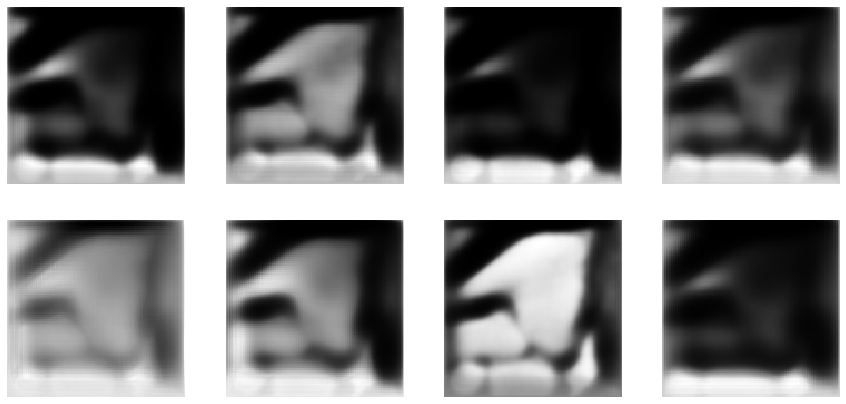

5/5 [==============================] - 7s 1s/step - loss: 0.7845
Epoch 22/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7755
Epoch 23/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7673
Epoch 24/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7612
Epoch 25/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7613
Epoch 26/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7503
Epoch 27/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7498
Epoch 28/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7458
Epoch 29/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7382
Epoch 30/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7367
Epoch 31/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7283
Epoch 32/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7238
Epoch 33/1000
5/5 [==============================] - 6s 1s/step - 

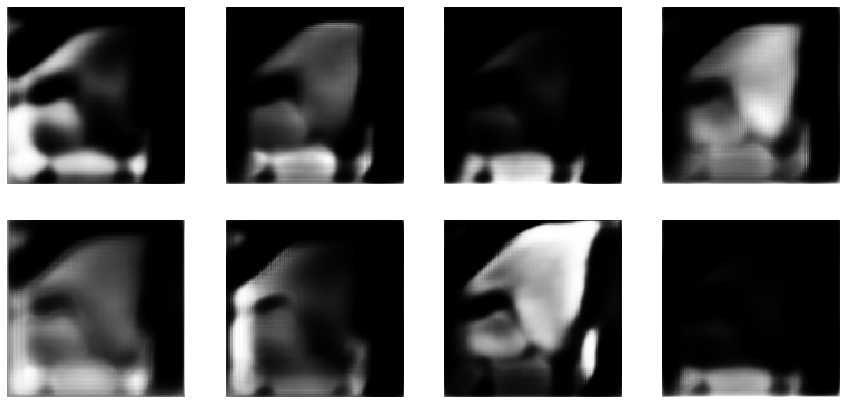

5/5 [==============================] - 7s 1s/step - loss: 0.6982
Epoch 42/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6939
Epoch 43/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6884
Epoch 44/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6877
Epoch 45/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6855
Epoch 46/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6860
Epoch 47/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6836
Epoch 48/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6823
Epoch 49/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6907
Epoch 50/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6791
Epoch 51/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6842
Epoch 52/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6725
Epoch 53/1000
5/5 [==============================] - 6s 1s/step - 

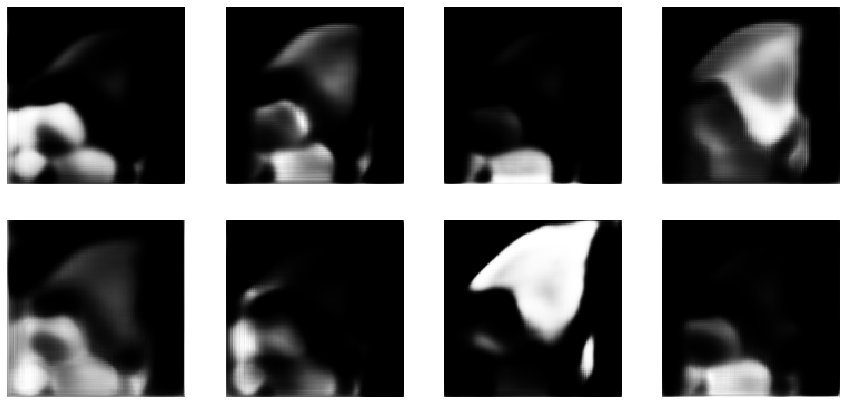

5/5 [==============================] - 7s 1s/step - loss: 0.6483
Epoch 62/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6341
Epoch 63/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6352
Epoch 64/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6363
Epoch 65/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6347
Epoch 66/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6325
Epoch 67/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6267
Epoch 68/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6266
Epoch 69/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6257
Epoch 70/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6067
Epoch 71/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6070
Epoch 72/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6009
Epoch 73/1000
5/5 [==============================] - 6s 1s/step - 

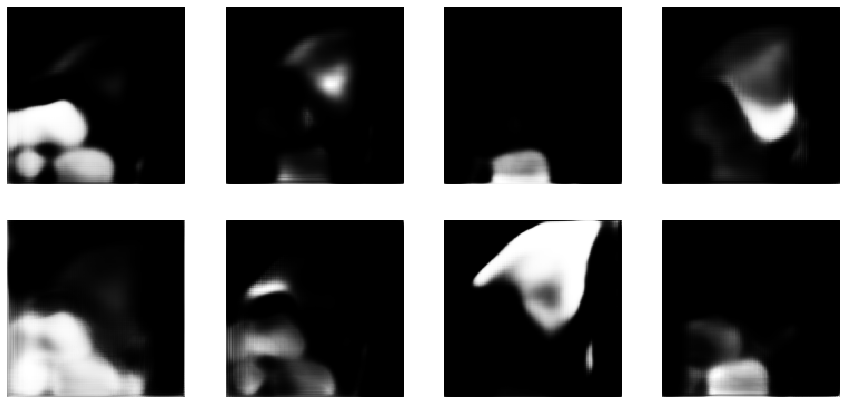

5/5 [==============================] - 6s 1s/step - loss: 0.5908
Epoch 82/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6031
Epoch 83/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5794
Epoch 84/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5844
Epoch 85/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5751
Epoch 86/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5697
Epoch 87/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5716
Epoch 88/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5818
Epoch 89/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5670
Epoch 90/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5869
Epoch 91/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5797
Epoch 92/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5935
Epoch 93/1000
5/5 [==============================] - 6s 1s/step - 

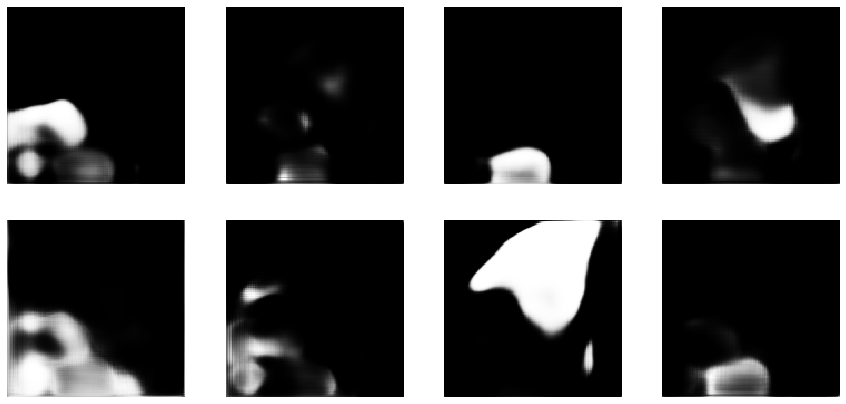

5/5 [==============================] - 6s 1s/step - loss: 0.5304
Epoch 102/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5216
Epoch 103/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5269
Epoch 104/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5239
Epoch 105/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5373
Epoch 106/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5240
Epoch 107/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5218
Epoch 108/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5141
Epoch 109/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5245
Epoch 110/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5311
Epoch 111/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5248
Epoch 112/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5169
Epoch 113/1000
5/5 [==============================] - 6

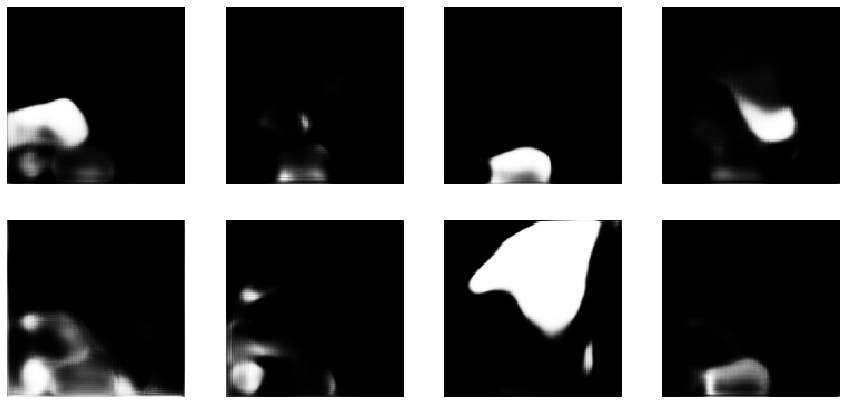

5/5 [==============================] - 7s 1s/step - loss: 0.4849
Epoch 122/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4910
Epoch 123/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4916
Epoch 124/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5078
Epoch 125/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4918
Epoch 126/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4868
Epoch 127/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4905
Epoch 128/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4837
Epoch 129/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4723
Epoch 130/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4733
Epoch 131/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4750
Epoch 132/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4930
Epoch 133/1000
5/5 [==============================] - 6

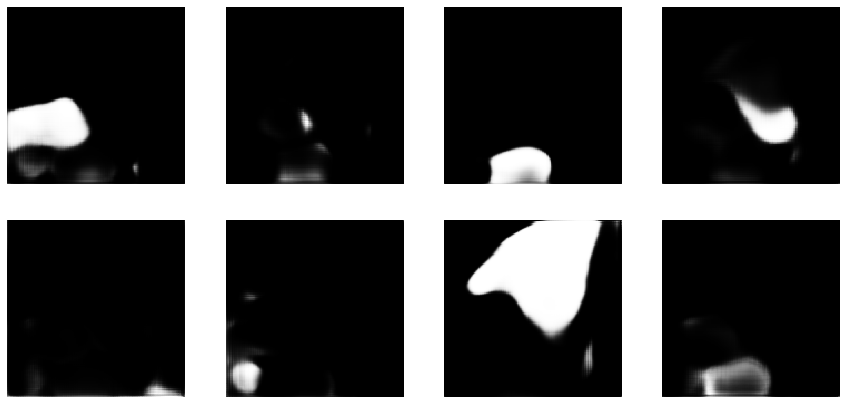

5/5 [==============================] - 6s 1s/step - loss: 0.4585
Epoch 142/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4587
Epoch 143/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4513
Epoch 144/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4433
Epoch 145/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4429
Epoch 146/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4394
Epoch 147/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4346
Epoch 148/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4384
Epoch 149/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4584
Epoch 150/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4391
Epoch 151/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4479
Epoch 152/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4342
Epoch 153/1000
5/5 [==============================] - 6

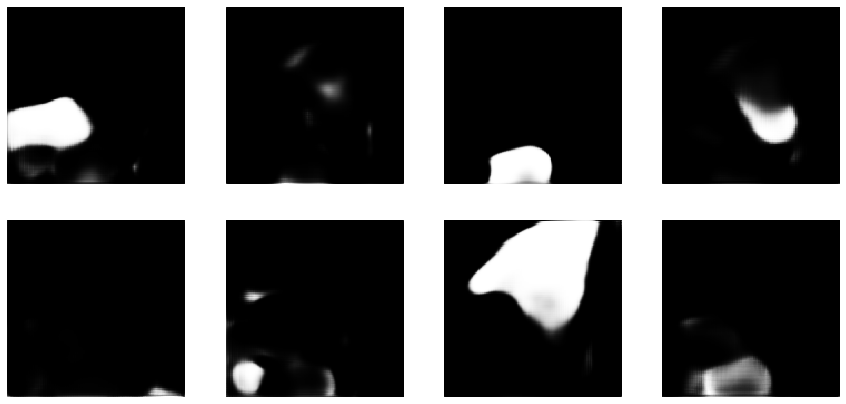

5/5 [==============================] - 6s 1s/step - loss: 0.4399
Epoch 162/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4443
Epoch 163/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4491
Epoch 164/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4583
Epoch 165/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4548
Epoch 166/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4470
Epoch 167/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4493
Epoch 168/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4400
Epoch 169/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4403
Epoch 170/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4399
Epoch 171/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4273
Epoch 172/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4210
Epoch 173/1000
5/5 [==============================] - 6

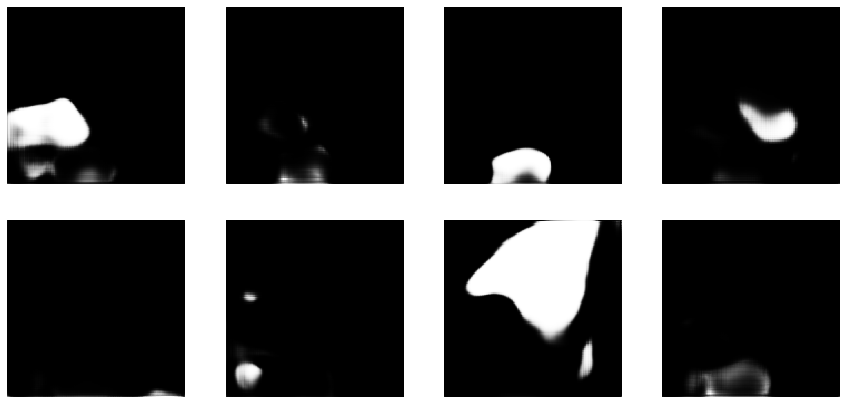

5/5 [==============================] - 6s 1s/step - loss: 0.4205
Epoch 182/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4385
Epoch 183/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4200
Epoch 184/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4173
Epoch 185/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4092
Epoch 186/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4105
Epoch 187/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4093
Epoch 188/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4191
Epoch 189/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4157
Epoch 190/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4188
Epoch 191/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4182
Epoch 192/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4269
Epoch 193/1000
5/5 [==============================] - 6

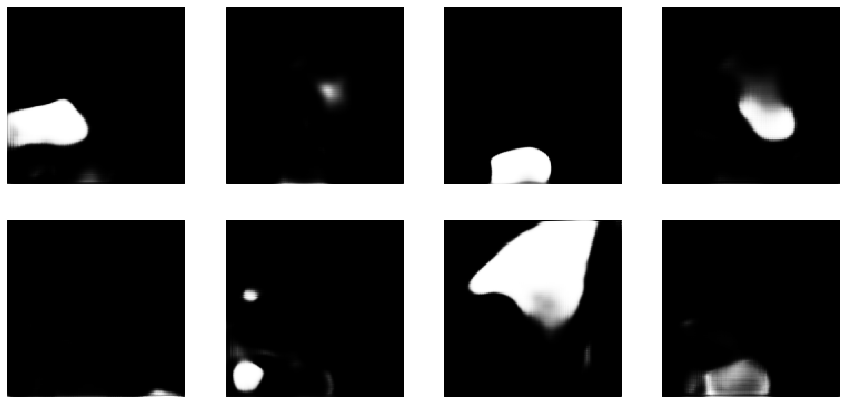

5/5 [==============================] - 6s 1s/step - loss: 0.3955
Epoch 202/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3987
Epoch 203/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3946
Epoch 204/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3918
Epoch 205/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3905
Epoch 206/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3890
Epoch 207/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3891
Epoch 208/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3870
Epoch 209/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3889
Epoch 210/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3872
Epoch 211/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3882
Epoch 212/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3858
Epoch 213/1000
5/5 [==============================] - 6

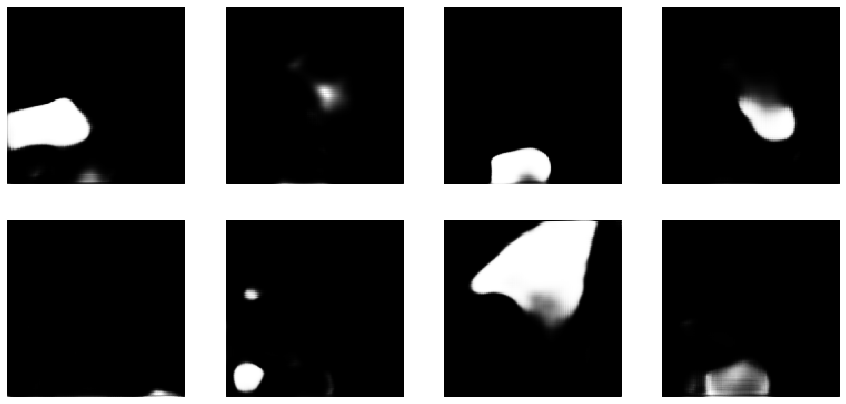

5/5 [==============================] - 7s 1s/step - loss: 0.3928
Epoch 222/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3901
Epoch 223/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3817
Epoch 224/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3800
Epoch 225/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3797
Epoch 226/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3789
Epoch 227/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3781
Epoch 228/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3807
Epoch 229/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3802
Epoch 230/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3867
Epoch 231/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4000
Epoch 232/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3942
Epoch 233/1000
5/5 [==============================] - 6

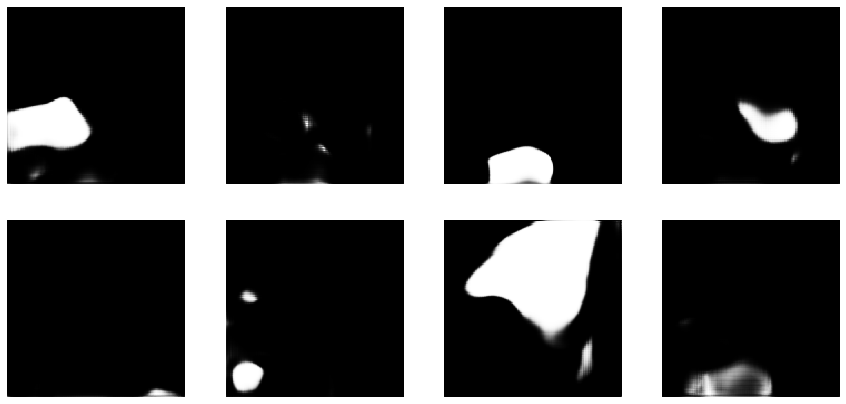

5/5 [==============================] - 6s 1s/step - loss: 0.3942
Epoch 242/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3835
Epoch 243/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3818
Epoch 244/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3793
Epoch 245/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3742
Epoch 246/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3777
Epoch 247/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3760
Epoch 248/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3708
Epoch 249/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3743
Epoch 250/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3779
Epoch 251/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3694
Epoch 252/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3688
Epoch 253/1000
5/5 [==============================] - 6

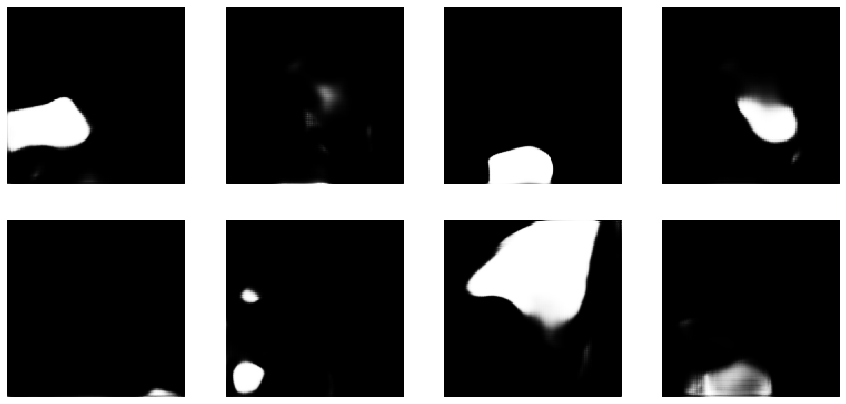

5/5 [==============================] - 6s 1s/step - loss: 0.3657
Epoch 262/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3721
Epoch 263/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3666
Epoch 264/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3658
Epoch 265/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3627
Epoch 266/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3623
Epoch 267/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3613
Epoch 268/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3606
Epoch 269/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3595
Epoch 270/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3590
Epoch 271/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3582
Epoch 272/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3583
Epoch 273/1000
5/5 [==============================] - 6

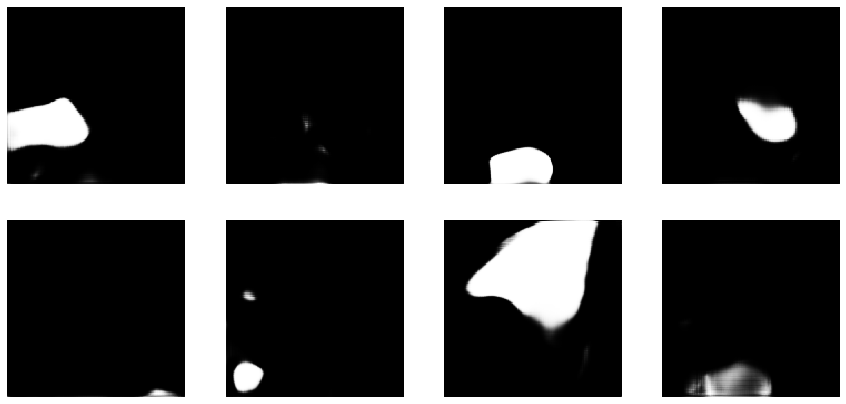

5/5 [==============================] - 7s 1s/step - loss: 0.3687
Epoch 282/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3705
Epoch 283/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3641
Epoch 284/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3620
Epoch 285/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3592
Epoch 286/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3570
Epoch 287/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3555
Epoch 288/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3569
Epoch 289/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3557
Epoch 290/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3548
Epoch 291/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3532
Epoch 292/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3524
Epoch 293/1000
5/5 [==============================] - 6

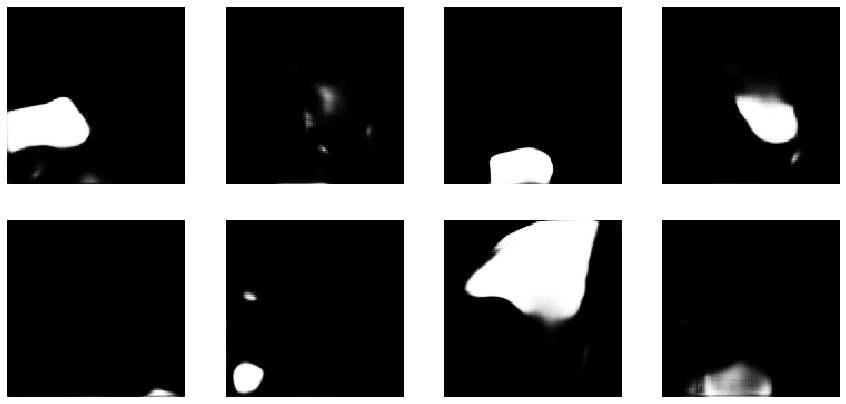

5/5 [==============================] - 6s 1s/step - loss: 0.3621
Epoch 302/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3604
Epoch 303/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3596
Epoch 304/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3601
Epoch 305/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3561
Epoch 306/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3567
Epoch 307/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3612
Epoch 308/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3571
Epoch 309/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3538
Epoch 310/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3534
Epoch 311/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3536
Epoch 312/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3521
Epoch 313/1000
5/5 [==============================] - 6

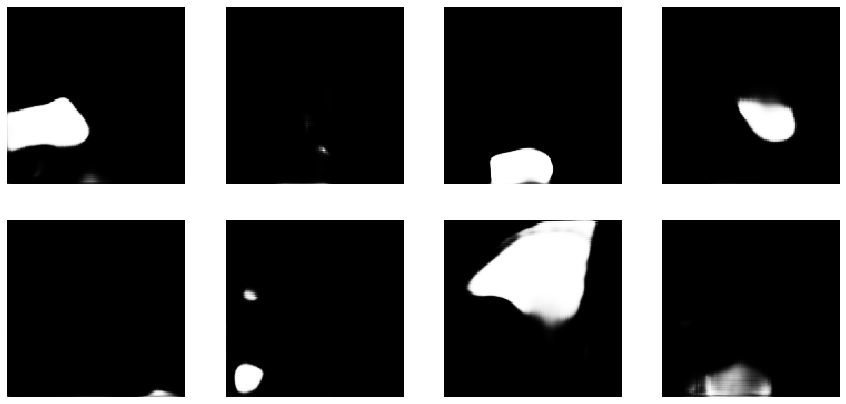

5/5 [==============================] - 6s 1s/step - loss: 0.3580
Epoch 322/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3597
Epoch 323/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3656
Epoch 324/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3591
Epoch 325/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3549
Epoch 326/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3556
Epoch 327/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3556
Epoch 328/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3587
Epoch 329/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3613
Epoch 330/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3612
Epoch 331/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3586
Epoch 332/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3578
Epoch 333/1000
5/5 [==============================] - 6

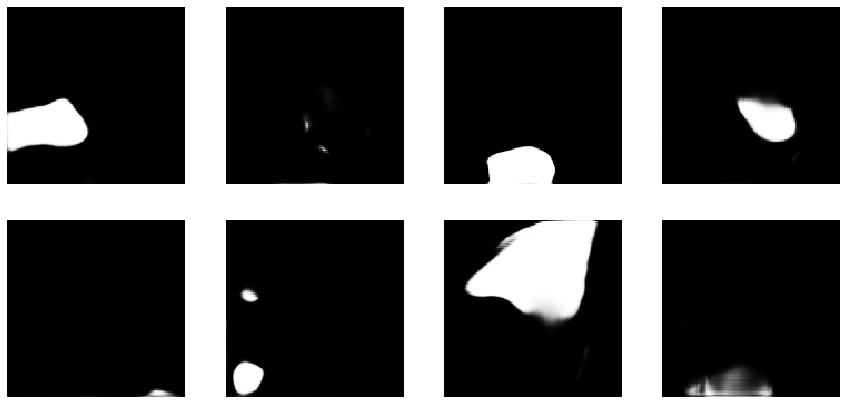

5/5 [==============================] - 7s 1s/step - loss: 0.3535
Epoch 342/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3531
Epoch 343/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3627
Epoch 344/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3693
Epoch 345/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3557
Epoch 346/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3561
Epoch 347/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3547
Epoch 348/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3528
Epoch 349/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3552
Epoch 350/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3504
Epoch 351/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3522
Epoch 352/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3517
Epoch 353/1000
5/5 [==============================] - 6

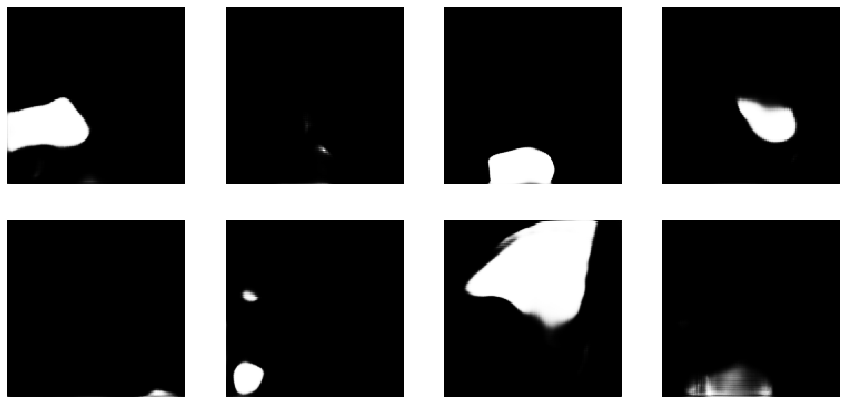

5/5 [==============================] - 6s 1s/step - loss: 0.3489
Epoch 362/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3495
Epoch 363/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3475
Epoch 364/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3455
Epoch 365/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3459
Epoch 366/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3458
Epoch 367/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3453
Epoch 368/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3464
Epoch 369/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3444
Epoch 370/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3433
Epoch 371/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3435
Epoch 372/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3421
Epoch 373/1000
5/5 [==============================] - 6

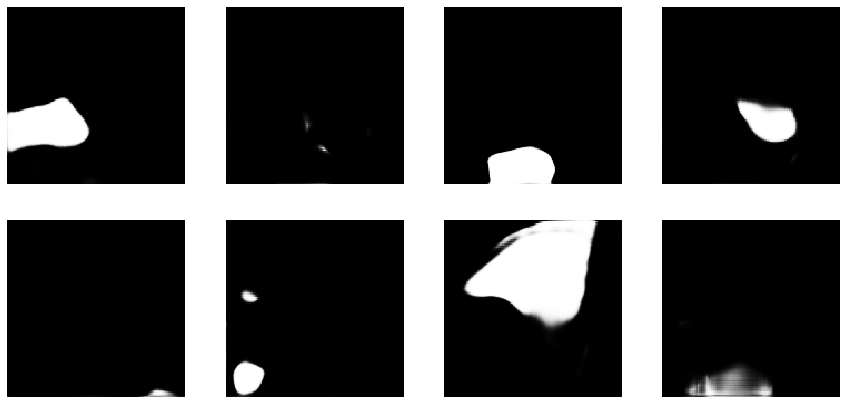

5/5 [==============================] - 7s 1s/step - loss: 0.3432
Epoch 382/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3424
Epoch 383/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3444
Epoch 384/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3493
Epoch 385/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3484
Epoch 386/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3633
Epoch 387/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3825
Epoch 388/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3790
Epoch 389/1000
5/5 [==============================] - 6s 1s/step - loss: 0.4000
Epoch 390/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3666
Epoch 391/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3975
Epoch 392/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3782
Epoch 393/1000
5/5 [==============================] - 6

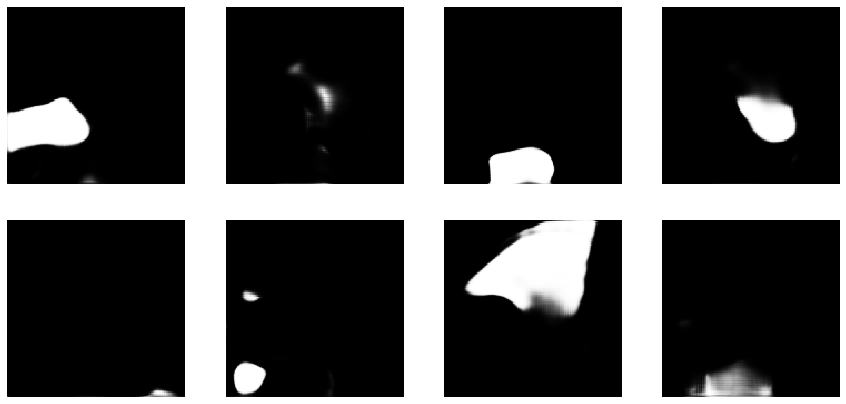

5/5 [==============================] - 6s 1s/step - loss: 0.3556
Epoch 402/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3518
Epoch 403/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3509
Epoch 404/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3463
Epoch 405/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3426
Epoch 406/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3403
Epoch 407/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3402
Epoch 408/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3394
Epoch 409/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3391
Epoch 410/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3394
Epoch 411/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3385
Epoch 412/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3383
Epoch 413/1000
5/5 [==============================] - 6

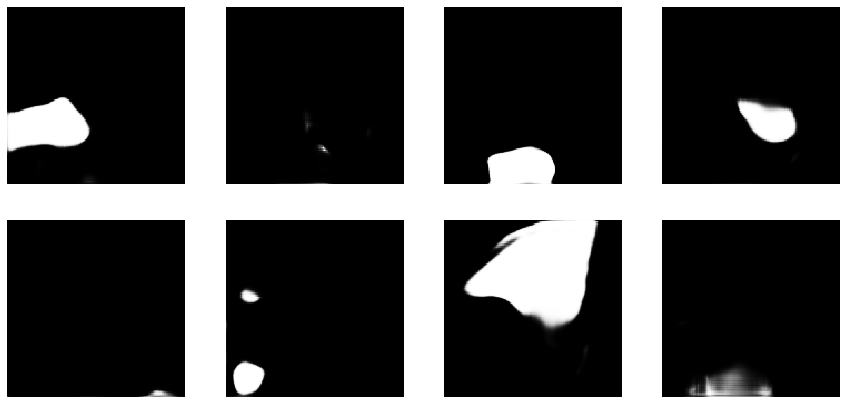

5/5 [==============================] - 6s 1s/step - loss: 0.3417
Epoch 422/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3411
Epoch 423/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3436
Epoch 424/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3413
Epoch 425/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3413
Epoch 426/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3404
Epoch 427/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3388
Epoch 428/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3392
Epoch 429/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3401
Epoch 430/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3400
Epoch 431/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3386
Epoch 432/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3380
Epoch 433/1000
5/5 [==============================] - 6

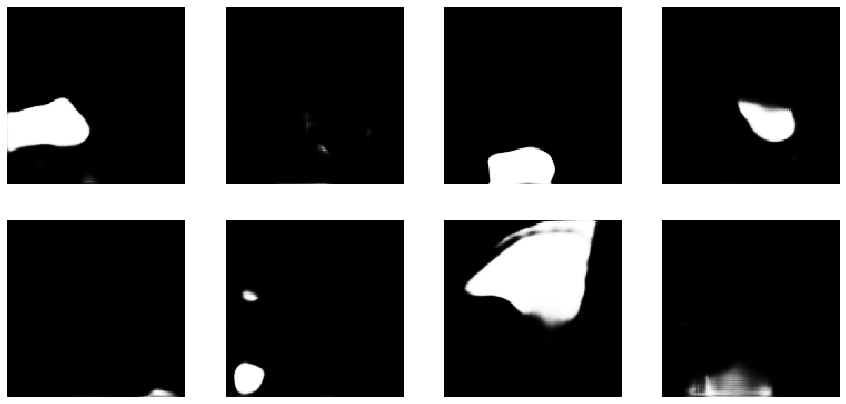

5/5 [==============================] - 6s 1s/step - loss: 0.3446
Epoch 442/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3450
Epoch 443/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3499
Epoch 444/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3502
Epoch 445/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3480
Epoch 446/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3441
Epoch 447/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3440
Epoch 448/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3433
Epoch 449/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3450
Epoch 450/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3404
Epoch 451/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3398
Epoch 452/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3384
Epoch 453/1000
5/5 [==============================] - 6

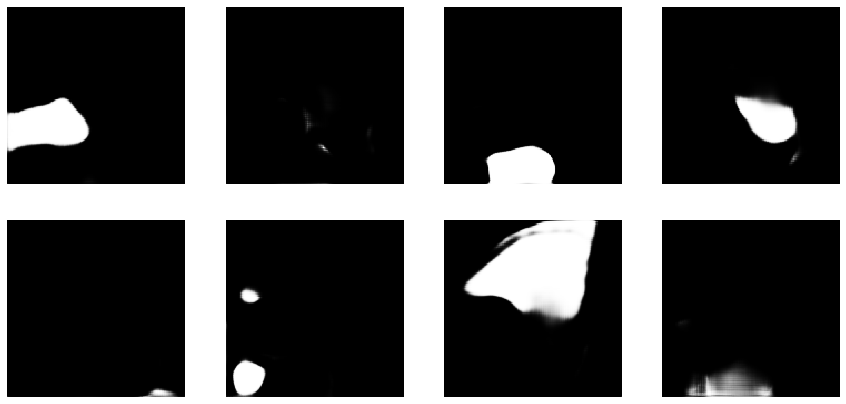

5/5 [==============================] - 6s 1s/step - loss: 0.3482
Epoch 462/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3493
Epoch 463/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3413
Epoch 464/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3388
Epoch 465/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3389
Epoch 466/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3398
Epoch 467/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3385
Epoch 468/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3377
Epoch 469/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3372
Epoch 470/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3392
Epoch 471/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3376
Epoch 472/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3361
Epoch 473/1000
5/5 [==============================] - 6

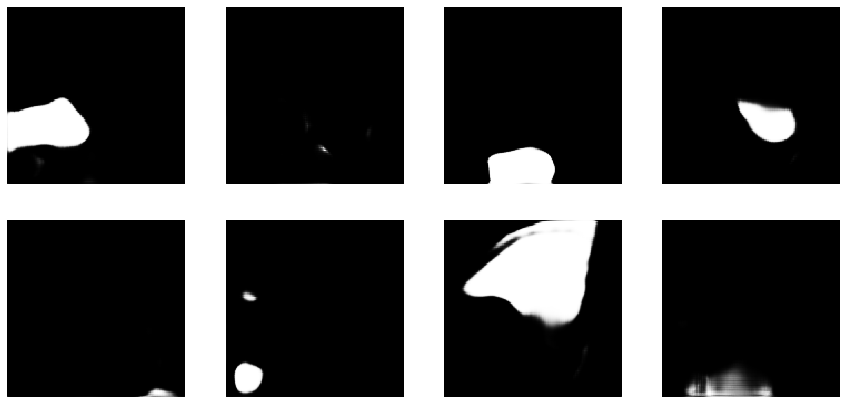

5/5 [==============================] - 6s 1s/step - loss: 0.3349
Epoch 482/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3386
Epoch 483/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3377
Epoch 484/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3450
Epoch 485/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3404
Epoch 486/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3426
Epoch 487/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3454
Epoch 488/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3413
Epoch 489/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3377
Epoch 490/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3373
Epoch 491/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3349
Epoch 492/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3343
Epoch 493/1000
5/5 [==============================] - 6

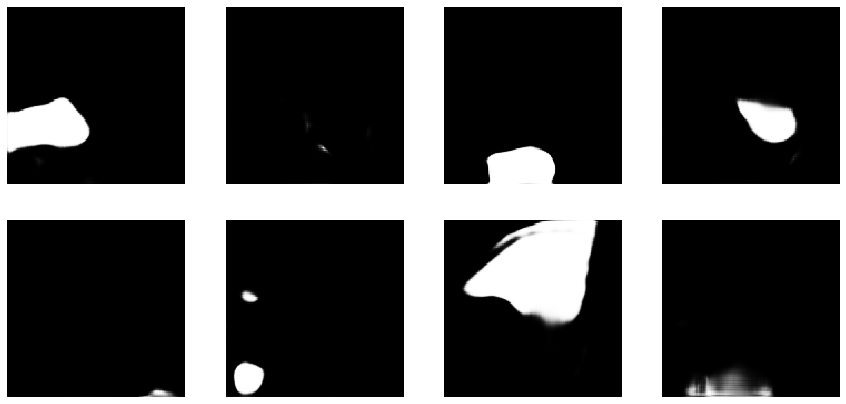

5/5 [==============================] - 6s 1s/step - loss: 0.3338
Epoch 502/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3335
Epoch 503/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3397
Epoch 504/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3389
Epoch 505/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3382
Epoch 506/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3345
Epoch 507/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3343
Epoch 508/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3348
Epoch 509/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3387
Epoch 510/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3377
Epoch 511/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3373
Epoch 512/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3359
Epoch 513/1000
5/5 [==============================] - 6

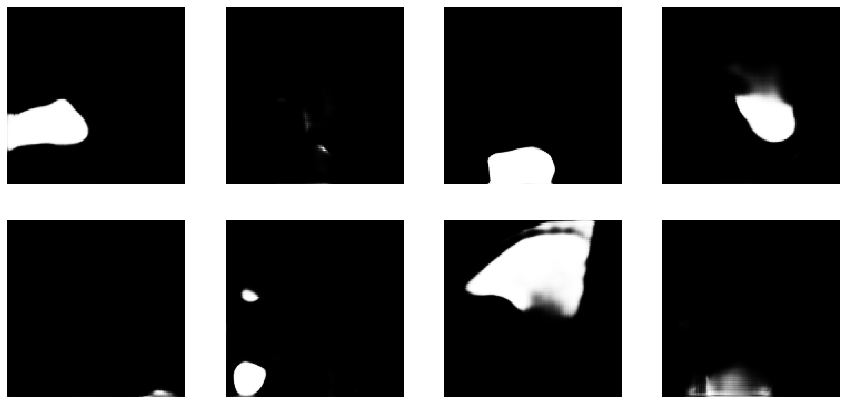

5/5 [==============================] - 6s 1s/step - loss: 0.3504
Epoch 522/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3486
Epoch 523/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3542
Epoch 524/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3573
Epoch 525/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3600
Epoch 526/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3639
Epoch 527/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3555
Epoch 528/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3447
Epoch 529/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3427
Epoch 530/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3386
Epoch 531/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3371
Epoch 532/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3370
Epoch 533/1000
5/5 [==============================] - 6

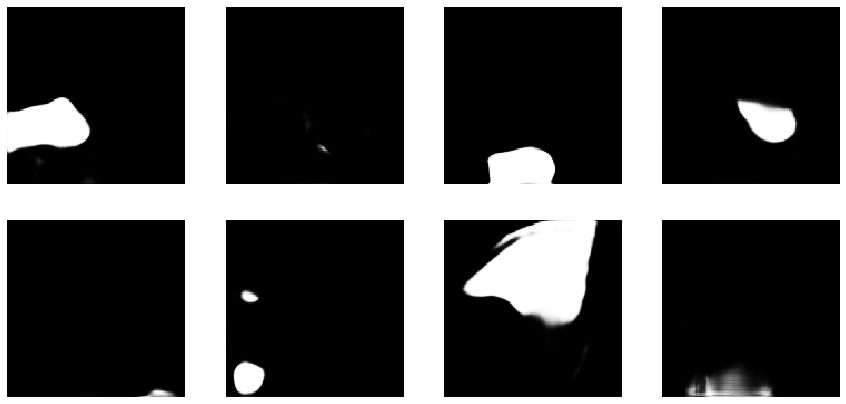

5/5 [==============================] - 7s 1s/step - loss: 0.3316
Epoch 542/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3310
Epoch 543/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3306
Epoch 544/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3302
Epoch 545/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 546/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 547/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 548/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3299
Epoch 549/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 550/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3306
Epoch 551/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3315
Epoch 552/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3313
Epoch 553/1000
5/5 [==============================] - 6

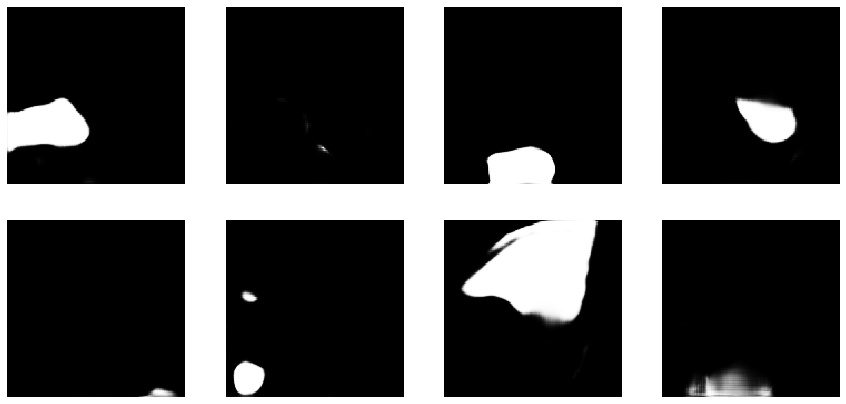

5/5 [==============================] - 6s 1s/step - loss: 0.3338
Epoch 562/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3327
Epoch 563/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3371
Epoch 564/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3331
Epoch 565/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3320
Epoch 566/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3322
Epoch 567/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3312
Epoch 568/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3310
Epoch 569/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3299
Epoch 570/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3298
Epoch 571/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 572/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3294
Epoch 573/1000
5/5 [==============================] - 6

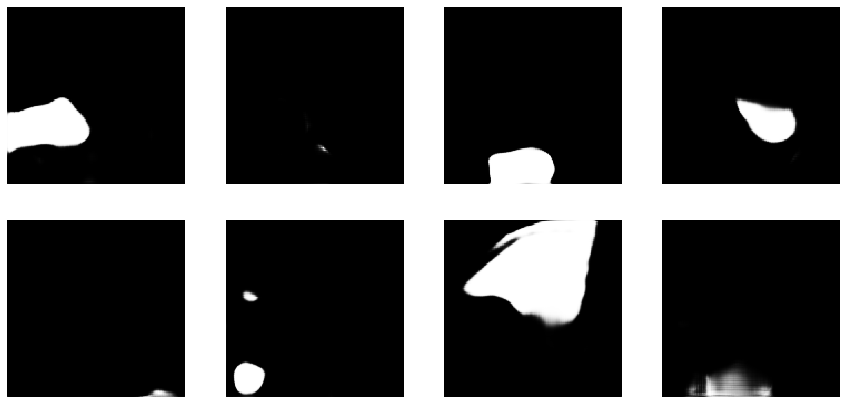

5/5 [==============================] - 6s 1s/step - loss: 0.3378
Epoch 582/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3340
Epoch 583/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3430
Epoch 584/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3368
Epoch 585/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3395
Epoch 586/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3348
Epoch 587/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3324
Epoch 588/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3313
Epoch 589/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3306
Epoch 590/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3298
Epoch 591/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3295
Epoch 592/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3300
Epoch 593/1000
5/5 [==============================] - 6

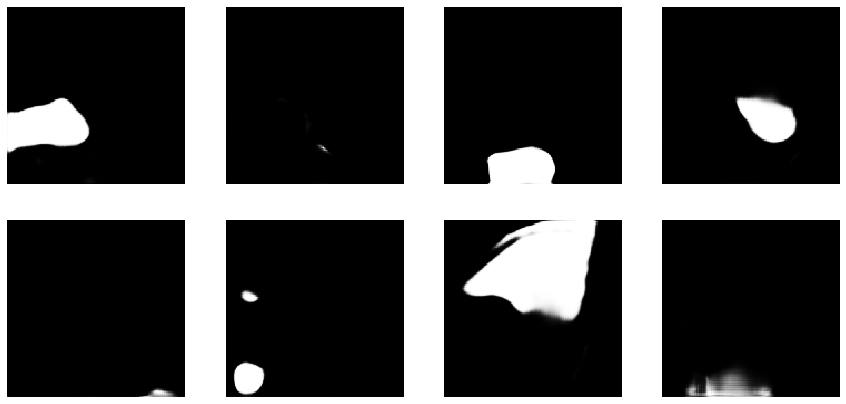

5/5 [==============================] - 6s 1s/step - loss: 0.3332
Epoch 602/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3308
Epoch 603/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3310
Epoch 604/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3317
Epoch 605/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3322
Epoch 606/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3328
Epoch 607/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3314
Epoch 608/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3319
Epoch 609/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3343
Epoch 610/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3324
Epoch 611/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3318
Epoch 612/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3309
Epoch 613/1000
5/5 [==============================] - 6

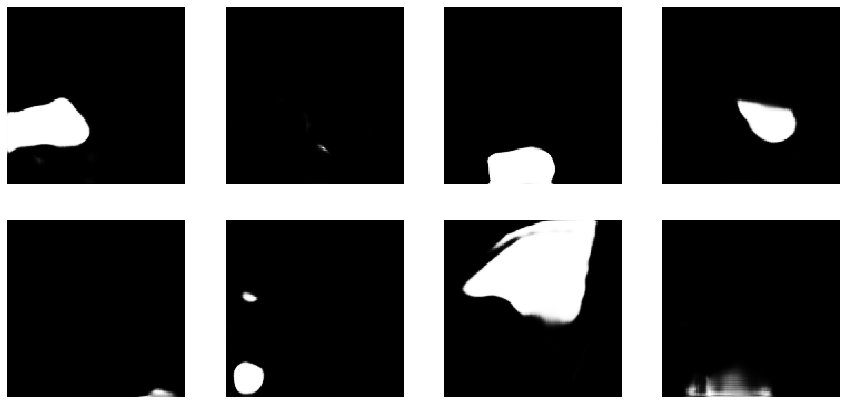

5/5 [==============================] - 6s 1s/step - loss: 0.3271
Epoch 622/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3270
Epoch 623/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3286
Epoch 624/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3280
Epoch 625/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3287
Epoch 626/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3302
Epoch 627/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3291
Epoch 628/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3279
Epoch 629/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3298
Epoch 630/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3304
Epoch 631/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3301
Epoch 632/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3315
Epoch 633/1000
5/5 [==============================] - 6

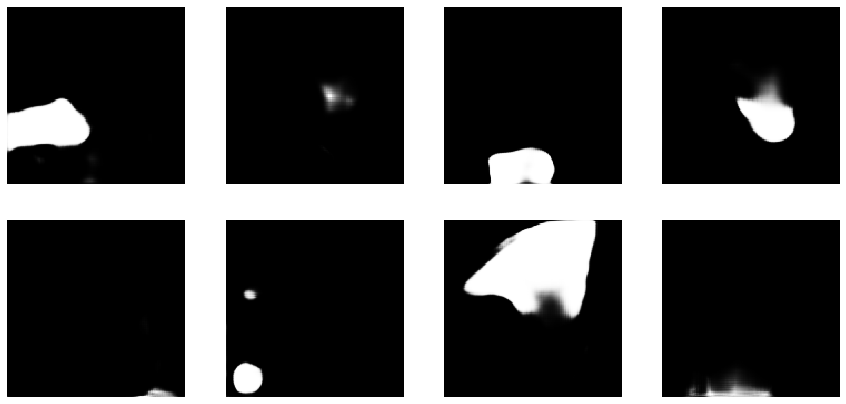

5/5 [==============================] - 6s 1s/step - loss: 0.3728
Epoch 642/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3731
Epoch 643/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3680
Epoch 644/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3534
Epoch 645/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3622
Epoch 646/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3580
Epoch 647/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3609
Epoch 648/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3506
Epoch 649/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3445
Epoch 650/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3361
Epoch 651/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3344
Epoch 652/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3328
Epoch 653/1000
5/5 [==============================] - 6

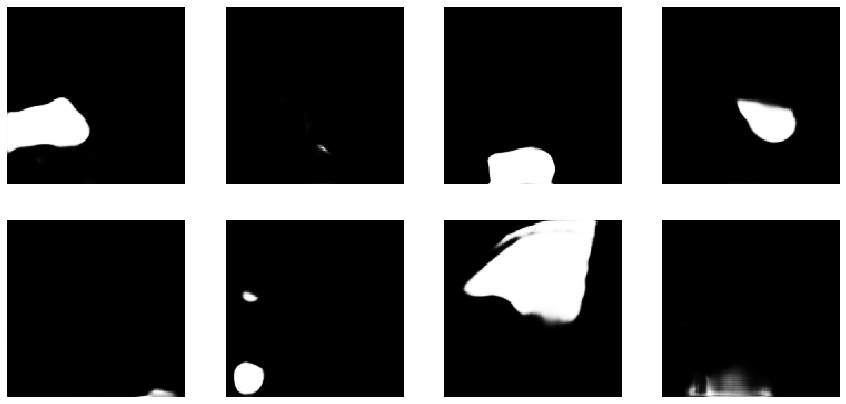

5/5 [==============================] - 6s 1s/step - loss: 0.3265
Epoch 662/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3265
Epoch 663/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3270
Epoch 664/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3277
Epoch 665/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3298
Epoch 666/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3311
Epoch 667/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3302
Epoch 668/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3307
Epoch 669/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3285
Epoch 670/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3308
Epoch 671/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3284
Epoch 672/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3289
Epoch 673/1000
5/5 [==============================] - 6

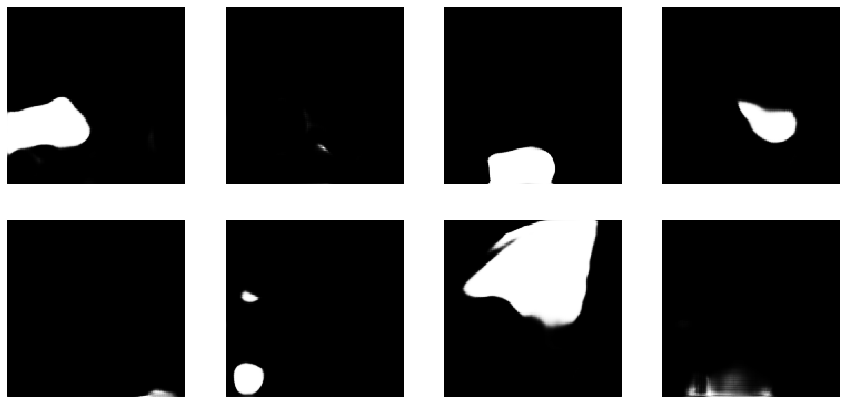

5/5 [==============================] - 6s 1s/step - loss: 0.3446
Epoch 682/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3404
Epoch 683/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3357
Epoch 684/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3353
Epoch 685/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3333
Epoch 686/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3311
Epoch 687/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3277
Epoch 688/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3277
Epoch 689/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3260
Epoch 690/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3260
Epoch 691/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3264
Epoch 692/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3259
Epoch 693/1000
5/5 [==============================] - 6

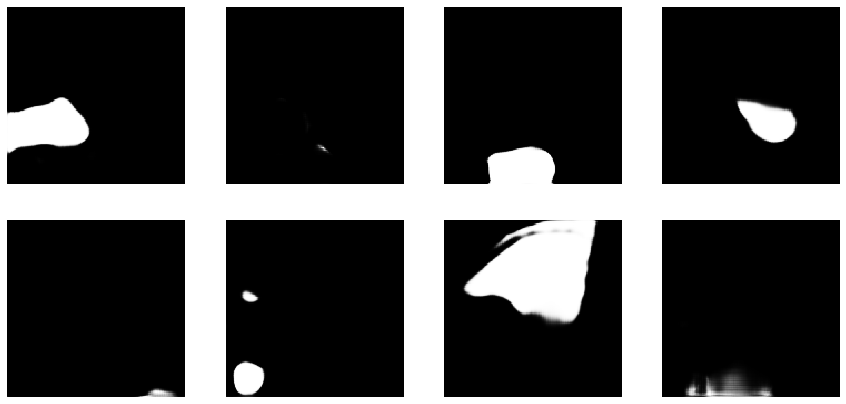

5/5 [==============================] - 7s 1s/step - loss: 0.3241
Epoch 702/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3230
Epoch 703/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3223
Epoch 704/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3223
Epoch 705/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3226
Epoch 706/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3232
Epoch 707/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3246
Epoch 708/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3259
Epoch 709/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3255
Epoch 710/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3251
Epoch 711/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3287
Epoch 712/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3260
Epoch 713/1000
5/5 [==============================] - 6

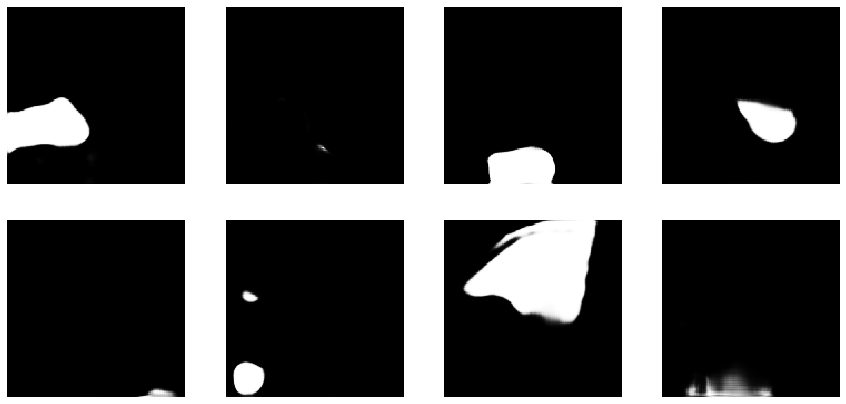

5/5 [==============================] - 7s 1s/step - loss: 0.3231
Epoch 722/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3237
Epoch 723/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3268
Epoch 724/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3256
Epoch 725/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3245
Epoch 726/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3231
Epoch 727/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3214
Epoch 728/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3237
Epoch 729/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3232
Epoch 730/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3247
Epoch 731/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3240
Epoch 732/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3240
Epoch 733/1000
5/5 [==============================] - 6

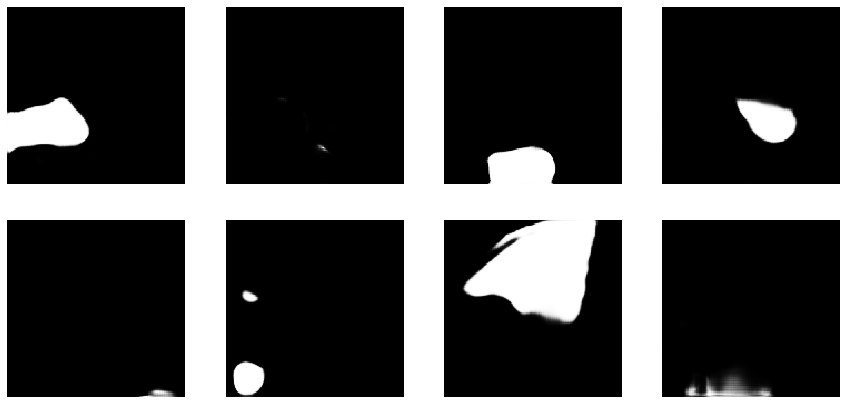

5/5 [==============================] - 6s 1s/step - loss: 0.3204
Epoch 742/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3219
Epoch 743/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3214
Epoch 744/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3210
Epoch 745/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3216
Epoch 746/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3215
Epoch 747/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3208
Epoch 748/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3214
Epoch 749/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3218
Epoch 750/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3226
Epoch 751/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3223
Epoch 752/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3223
Epoch 753/1000
5/5 [==============================] - 6

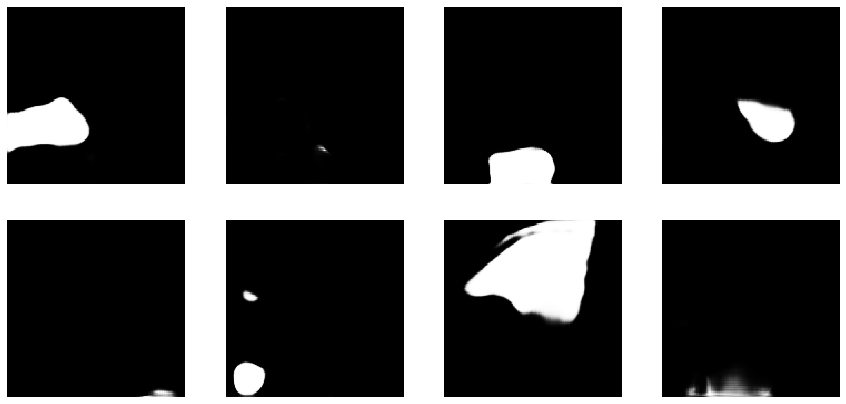

5/5 [==============================] - 6s 1s/step - loss: 0.3273
Epoch 762/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3265
Epoch 763/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3225
Epoch 764/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3220
Epoch 765/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3204
Epoch 766/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3202
Epoch 767/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3194
Epoch 768/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3187
Epoch 769/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3183
Epoch 770/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3197
Epoch 771/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3175
Epoch 772/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3178
Epoch 773/1000
5/5 [==============================] - 6

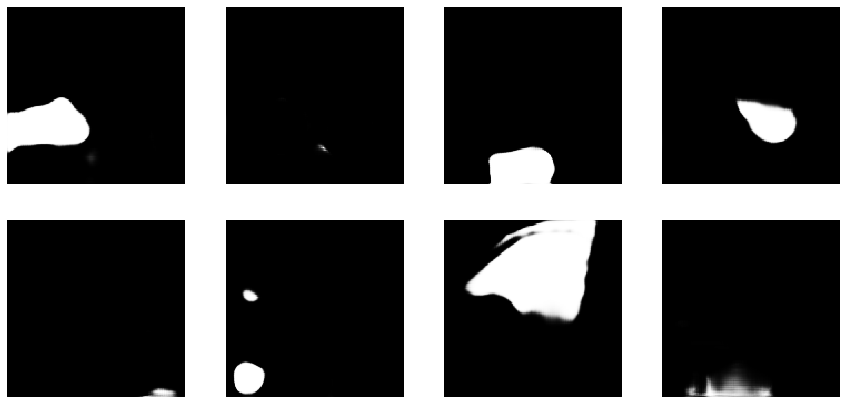

5/5 [==============================] - 6s 1s/step - loss: 0.3223
Epoch 782/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3207
Epoch 783/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3194
Epoch 784/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3191
Epoch 785/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3294
Epoch 786/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3303
Epoch 787/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3340
Epoch 788/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3286
Epoch 789/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3256
Epoch 790/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3246
Epoch 791/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3242
Epoch 792/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3271
Epoch 793/1000
5/5 [==============================] - 6

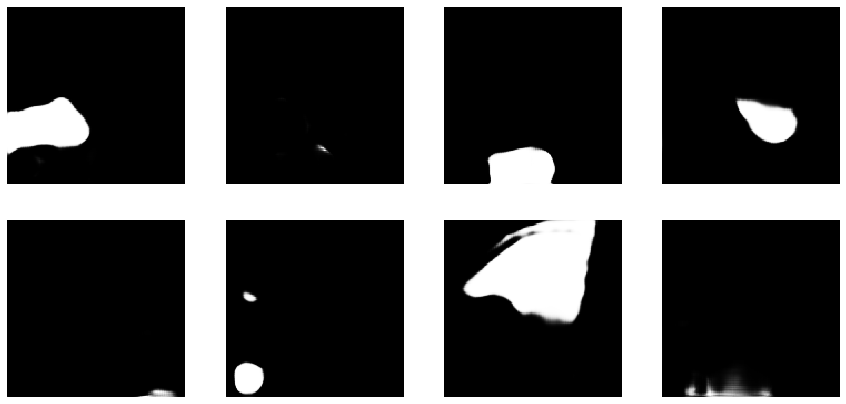

5/5 [==============================] - 6s 1s/step - loss: 0.3182
Epoch 802/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3166
Epoch 803/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3142
Epoch 804/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3134
Epoch 805/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3132
Epoch 806/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3127
Epoch 807/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3145
Epoch 808/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3144
Epoch 809/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3149
Epoch 810/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3173
Epoch 811/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3157
Epoch 812/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3145
Epoch 813/1000
5/5 [==============================] - 6

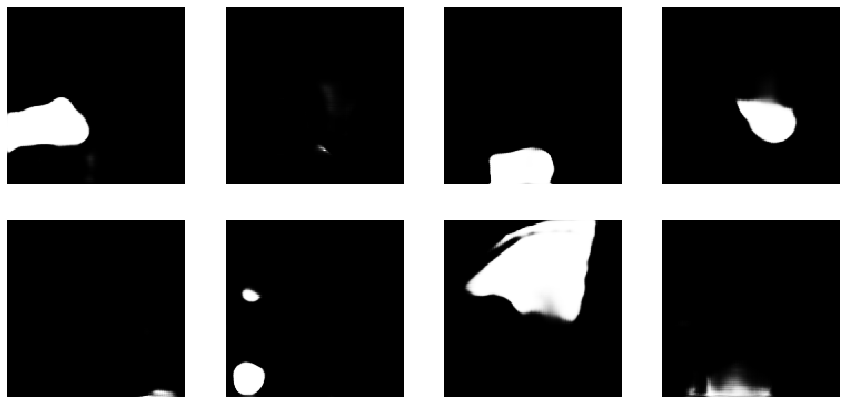

5/5 [==============================] - 6s 1s/step - loss: 0.3208
Epoch 822/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3196
Epoch 823/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3161
Epoch 824/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3145
Epoch 825/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3138
Epoch 826/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3130
Epoch 827/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3122
Epoch 828/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3120
Epoch 829/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3122
Epoch 830/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3122
Epoch 831/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3118
Epoch 832/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3149
Epoch 833/1000
5/5 [==============================] - 6

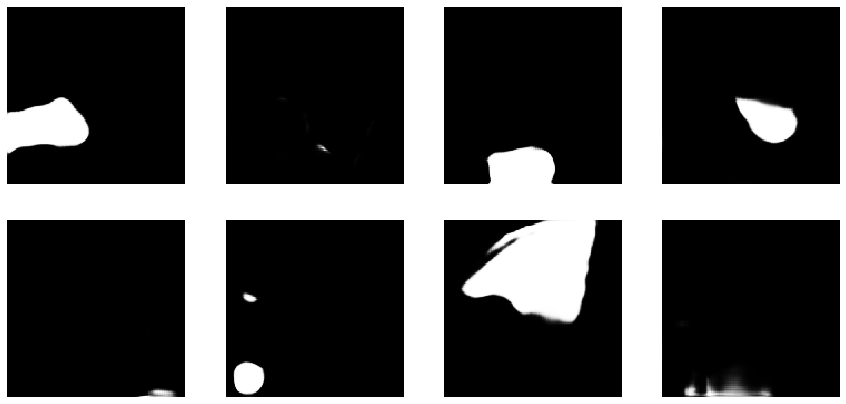

5/5 [==============================] - 6s 1s/step - loss: 0.3156
Epoch 842/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3153
Epoch 843/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3139
Epoch 844/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3117
Epoch 845/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3136
Epoch 846/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3116
Epoch 847/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3112
Epoch 848/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3104
Epoch 849/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3107
Epoch 850/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3104
Epoch 851/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3103
Epoch 852/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3104
Epoch 853/1000
5/5 [==============================] - 6

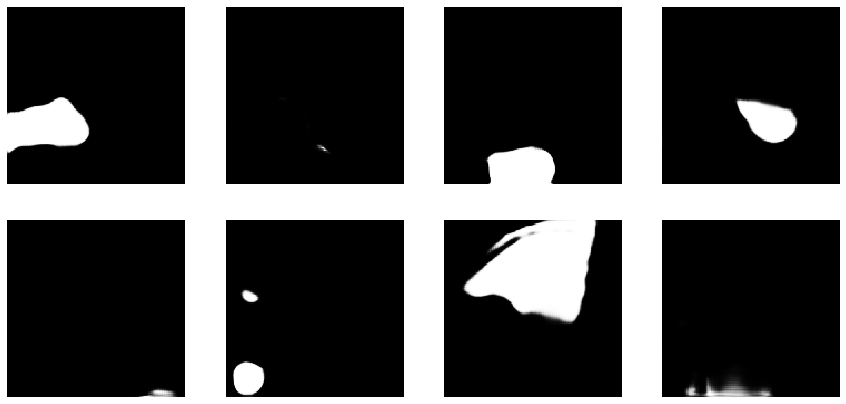

5/5 [==============================] - 7s 1s/step - loss: 0.3098
Epoch 862/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3108
Epoch 863/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3121
Epoch 864/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3127
Epoch 865/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3121
Epoch 866/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3113
Epoch 867/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3121
Epoch 868/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3127
Epoch 869/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3124
Epoch 870/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3115
Epoch 871/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3136
Epoch 872/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3122
Epoch 873/1000
5/5 [==============================] - 6

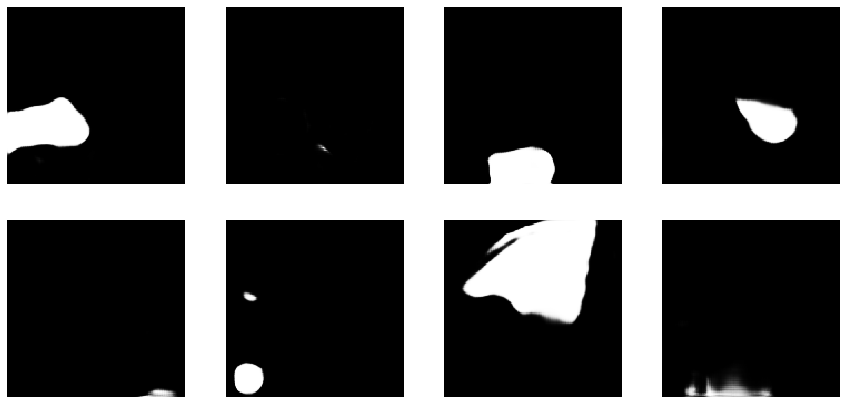

5/5 [==============================] - 6s 1s/step - loss: 0.3152
Epoch 882/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3140
Epoch 883/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3155
Epoch 884/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3197
Epoch 885/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3196
Epoch 886/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3153
Epoch 887/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3131
Epoch 888/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3125
Epoch 889/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3128
Epoch 890/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3117
Epoch 891/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3144
Epoch 892/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3158
Epoch 893/1000
5/5 [==============================] - 6

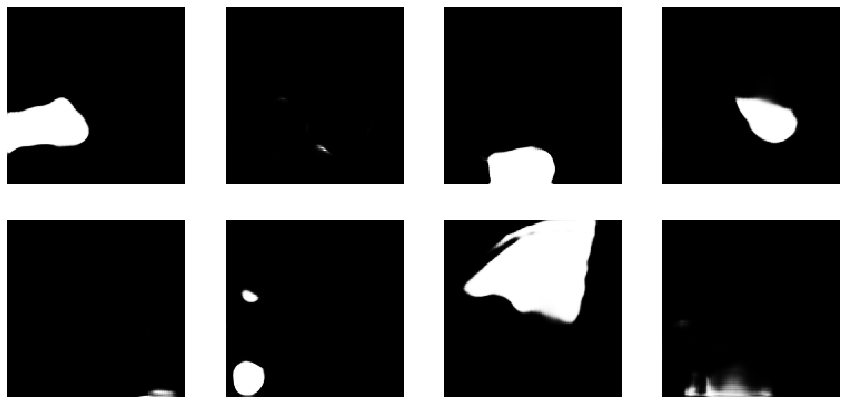

5/5 [==============================] - 6s 1s/step - loss: 0.3158
Epoch 902/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3157
Epoch 903/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3141
Epoch 904/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3125
Epoch 905/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3120
Epoch 906/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3125
Epoch 907/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3130
Epoch 908/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3166
Epoch 909/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3181
Epoch 910/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3165
Epoch 911/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3154
Epoch 912/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3149
Epoch 913/1000
5/5 [==============================] - 6

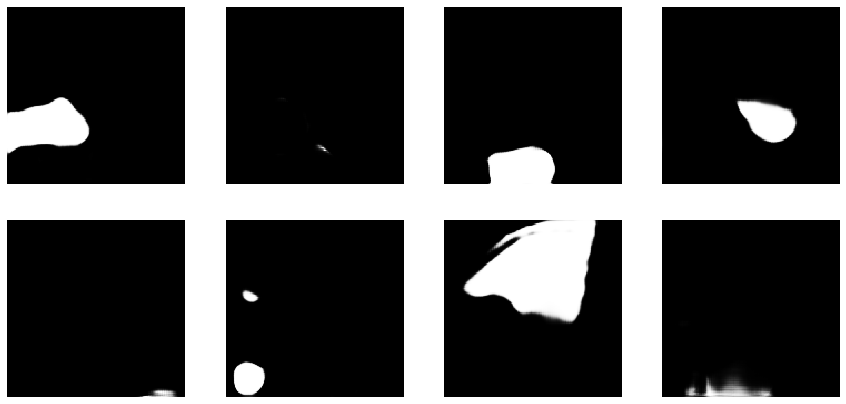

5/5 [==============================] - 6s 1s/step - loss: 0.3121
Epoch 922/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3118
Epoch 923/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3112
Epoch 924/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3105
Epoch 925/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3119
Epoch 926/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3111
Epoch 927/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3093
Epoch 928/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3089
Epoch 929/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3091
Epoch 930/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3088
Epoch 931/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3086
Epoch 932/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3087
Epoch 933/1000
5/5 [==============================] - 6

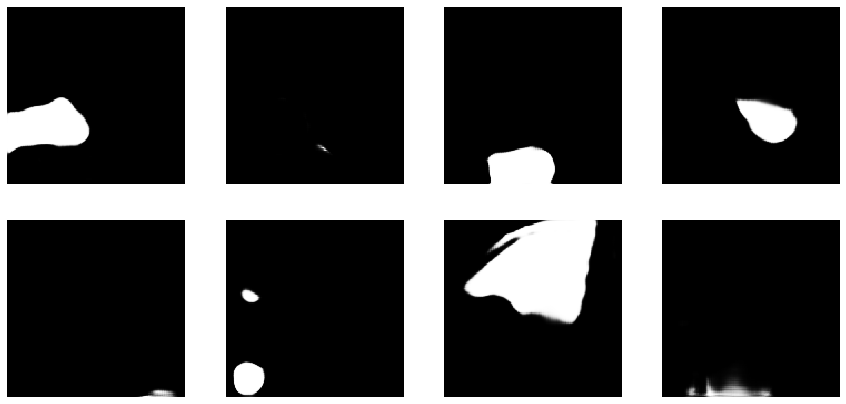

5/5 [==============================] - 6s 1s/step - loss: 0.3100
Epoch 942/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3097
Epoch 943/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3101
Epoch 944/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3109
Epoch 945/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3113
Epoch 946/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3133
Epoch 947/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3143
Epoch 948/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3221
Epoch 949/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3157
Epoch 950/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3124
Epoch 951/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3105
Epoch 952/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3109
Epoch 953/1000
5/5 [==============================] - 6

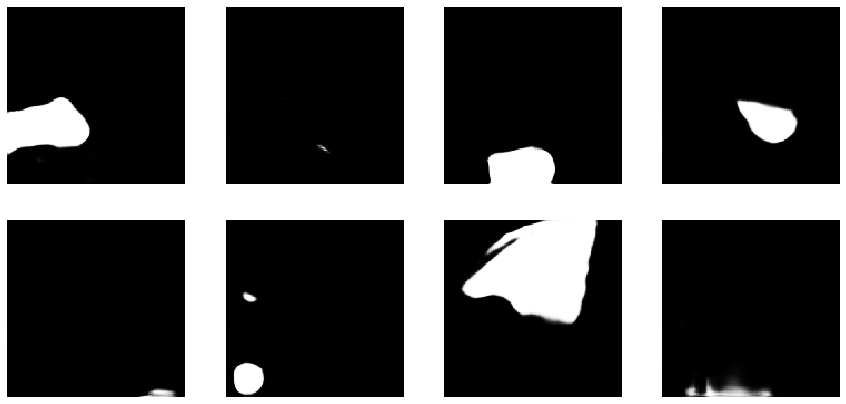

5/5 [==============================] - 6s 1s/step - loss: 0.3083
Epoch 962/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3096
Epoch 963/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3089
Epoch 964/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3103
Epoch 965/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3113
Epoch 966/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3109
Epoch 967/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3112
Epoch 968/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3109
Epoch 969/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3114
Epoch 970/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3160
Epoch 971/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3200
Epoch 972/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3173
Epoch 973/1000
5/5 [==============================] - 6

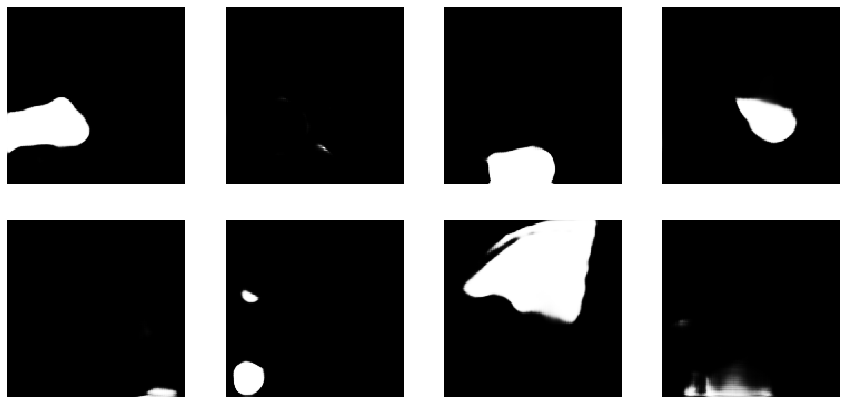

5/5 [==============================] - 6s 1s/step - loss: 0.3124
Epoch 982/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3151
Epoch 983/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3143
Epoch 984/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3117
Epoch 985/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3109
Epoch 986/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3114
Epoch 987/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3102
Epoch 988/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3098
Epoch 989/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3093
Epoch 990/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3092
Epoch 991/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3108
Epoch 992/1000
5/5 [==============================] - 6s 1s/step - loss: 0.3110
Epoch 993/1000
5/5 [==============================] - 6

In [25]:
model = unet_model_3d(loss_function=soft_dice_loss)
steps_per_epoch = 5
n_epochs=1000
# validation_steps = 20

def display(data, num_ch=3, slice=45):
  # if num_ch==4:
  #   titles = ['t1', 't2', 'flair', 't1ce']
  # elif num_ch==3:
  #   titles = ['ncr', 'ed', 'et']
  plt.figure(figsize=(15, 15))
  for i in range(num_ch):
    plt.subplot(4, 4, i+1)
    # plt.title(titles[i])
    plt.imshow(data[0, i, :, :, slice], cmap='gray')
    plt.axis('off')
  plt.show()  

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch%20 == 0:
      output = model(sample_input)
      # clear_output(wait=True)
      display(output, 8, 7)
      # print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


history = model.fit(ds,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs, 
        callbacks=[DisplayCallback()])


In [29]:


print(sample_input.shape)
output = model(sample_input)
print(output.shape)
# output = output>.9

def display(data, num_ch=3, slice=45):
  # if num_ch==4:
  #   titles = ['t1', 't2', 'flair', 't1ce']
  # elif num_ch==3:
  #   titles = ['ncr', 'ed', 'et']
  plt.figure(figsize=(15, 15))
  for i in range(num_ch):
    plt.subplot(4, 4, i+1)
    # plt.title(titles[i])
    plt.imshow(data[0, i, :, :, slice], cmap='gray')
    plt.axis('off')
  plt.show()  

def explore_3dimage(layer):

  plt.figure(figsize=(15, 15))
  display(sample_label, 8, layer)
  display(output>.5, 8, layer)
  display(sample_input, 1, layer)
  display(output, 8, layer)

interact(explore_3dimage, layer=(0, 16 - 1))


(2, 1, 160, 160, 16)
(2, 8, 160, 160, 16)


interactive(children=(IntSlider(value=7, description='layer', max=15), Output()), _dom_classes=('widget-intera…

<function __main__.explore_3dimage(layer)>

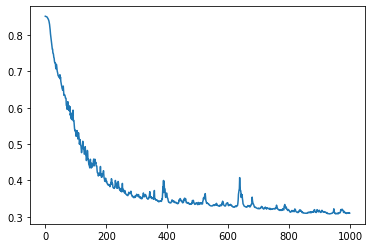

In [27]:
plt.plot(history.history['loss'])